In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
features = pd.read_csv('Features data set.csv')
sales = pd.read_csv('sales data-set.csv')
stores = pd.read_csv('stores data-set.csv')

In [3]:
features = features.drop(['IsHoliday'], axis=1)

combined = sales.merge(features, on=['Store', 'Date'])
combined = combined.merge(stores, on=['Store'])

combined.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,05/02/2010,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,12/02/2010,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,05/03/2010,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [4]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [5]:
combined = combined.fillna(value=0)

In [6]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     421570 non-null  float64
 8   MarkDown2     421570 non-null  float64
 9   MarkDown3     421570 non-null  float64
 10  MarkDown4     421570 non-null  float64
 11  MarkDown5     421570 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [7]:
merged_df = combined.groupby(['Store', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
                               'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'], as_index=False).sum()

merged_df = merged_df.drop(['Dept'], axis = 1)
print(merged_df.head())

   Store        Date  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
0      1  01/04/2011      False        59.17       3.524       0.00   
1      1  01/06/2012      False        77.95       3.501    6086.21   
2      1  01/07/2011      False        85.55       3.524       0.00   
3      1  01/10/2010      False        71.89       2.603       0.00   
4      1  02/03/2012      False        60.96       3.630   15441.40   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type  \
0        0.0       0.00       0.00       0.00  214.837166         7.682    A   
1       12.0     370.51     148.75    3690.85  221.747214         7.143    A   
2        0.0       0.00       0.00       0.00  215.184137         7.962    A   
3        0.0       0.00       0.00       0.00  211.671989         7.838    A   
4     1569.0      10.80   25390.88    8067.61  220.848045         7.348    A   

     Size  Weekly_Sales  
0  151315    1495064.75  
1  151315    1624477.58  
2  151315    1

In [8]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'], dayfirst=True)
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month

merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week
merged_df['WeekOfYear'] = merged_df['WeekOfYear'].astype(np.int32)

merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek

merged_df = merged_df.sort_values(by=['Store', 'Date'])
print(merged_df.head())

     Store       Date  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
19       1 2010-02-05      False        42.31       2.572        0.0   
52       1 2010-02-12       True        38.51       2.548        0.0   
85       1 2010-02-19      False        39.93       2.514        0.0   
118      1 2010-02-26      False        46.63       2.561        0.0   
20       1 2010-03-05      False        46.50       2.625        0.0   

     MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  \
19         0.0        0.0        0.0        0.0  211.096358         8.106   
52         0.0        0.0        0.0        0.0  211.242170         8.106   
85         0.0        0.0        0.0        0.0  211.289143         8.106   
118        0.0        0.0        0.0        0.0  211.319643         8.106   
20         0.0        0.0        0.0        0.0  211.350143         8.106   

    Type    Size  Weekly_Sales  Year  Month  WeekOfYear  DayOfWeek  
19     A  151315    1643690.90  201

In [9]:
merged_df['Holiday_Weight'] = 1

super_bowl_week = (merged_df['Date'].dt.month == 2) & (merged_df['Date'].dt.isocalendar().week <= 6) & (merged_df['Date'].dt.dayofweek == 6)
labor_day_week = (merged_df['Date'].dt.month == 9) & (merged_df['Date'].dt.isocalendar().week == 36)
thanksgiving_week = (merged_df['Date'].dt.month == 11) & (merged_df['Date'].dt.isocalendar().week == 47)
christmas_period = (merged_df['Date'].dt.month == 12) & (merged_df['Date'].dt.isocalendar().week <= 24)

merged_df.loc[super_bowl_week, 'Holiday_Weight'] = 5
merged_df.loc[labor_day_week, 'Holiday_Weight'] = 5
merged_df.loc[thanksgiving_week, 'Holiday_Weight'] = 5
merged_df.loc[christmas_period, 'Holiday_Weight'] = 5

merged_df['Weighted_Weekly_Sales'] = merged_df['Weekly_Sales'] * merged_df['Holiday_Weight']

merged_df.head()

,Store,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Unemployment,Type,Size,Weekly_Sales,Year,Month,WeekOfYear,DayOfWeek,Holiday_Weight,Weighted_Weekly_Sales
19,1,2010-02-05,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,8.106,A,151315,1643690.90,2010,2,5,4,1,1643690.90
52,1,2010-02-12,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,...,8.106,A,151315,1641957.44,2010,2,6,4,1,1641957.44
85,1,2010-02-19,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,...,8.106,A,151315,1611968.17,2010,2,7,4,1,1611968.17
118,1,2010-02-26,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,...,8.106,A,151315,1409727.59,2010,2,8,4,1,1409727.59
20,1,2010-03-05,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,...,8.106,A,151315,1554806.68,2010,3,9,4,1,1554806.68


In [10]:
label_encoder = LabelEncoder()
merged_df['Type'] = label_encoder.fit_transform(merged_df['Type'])
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 19 to 6413
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Store                  6435 non-null   int64         
 1   Date                   6435 non-null   datetime64[ns]
 2   IsHoliday              6435 non-null   bool          
 3   Temperature            6435 non-null   float64       
 4   Fuel_Price             6435 non-null   float64       
 5   MarkDown1              6435 non-null   float64       
 6   MarkDown2              6435 non-null   float64       
 7   MarkDown3              6435 non-null   float64       
 8   MarkDown4              6435 non-null   float64       
 9   MarkDown5              6435 non-null   float64       
 10  CPI                    6435 non-null   float64       
 11  Unemployment           6435 non-null   float64       
 12  Type                   6435 non-null   int32         
 13  Size   

Correlation of each feature with Weighted_Weekly_Sales:
Size            0.810468
MarkDown1       0.179107
MarkDown5       0.173273
MarkDown4       0.139195
MarkDown3       0.120289
MarkDown2       0.080157
Month           0.076143
WeekOfYear      0.074211
Fuel_Price      0.009464
Year           -0.018378
Temperature    -0.063810
CPI            -0.072634
Unemployment   -0.106176
Store          -0.335332
Type           -0.598380
DayOfWeek            NaN
dtype: float64


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


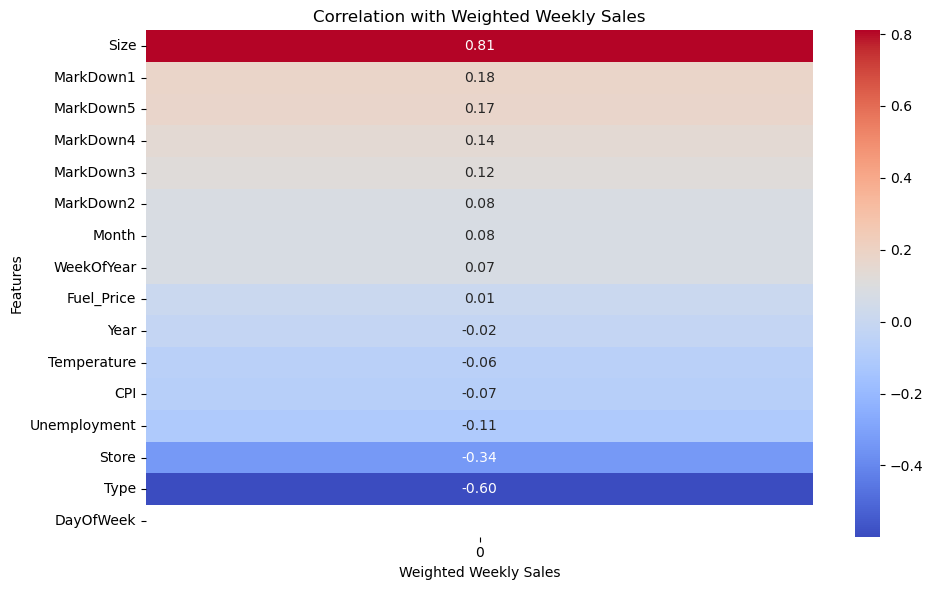

In [11]:
numeric_df = merged_df.select_dtypes(include=[np.number]).drop(columns=['Weekly_Sales', 'Weighted_Weekly_Sales', 'Holiday_Weight', ])

# Compute correlation matrix
correlation = numeric_df.corrwith(merged_df['Weekly_Sales']).sort_values(ascending=False)

print("Correlation of each feature with Weighted_Weekly_Sales:")
print(correlation)

plt.figure(figsize=(10, 6))

sns.heatmap(correlation.to_frame(), annot=True, cmap="coolwarm", cbar=True, fmt=".2f")

plt.title("Correlation with Weighted Weekly Sales")

plt.xlabel("Weighted Weekly Sales")

plt.ylabel("Features")

plt.tight_layout()

plt.show()

[0.22668357 0.15088926 0.12000742 0.10824811 0.09263525 0.08276386
 0.07737273 0.06482042 0.04500113 0.01876137 0.01281688]


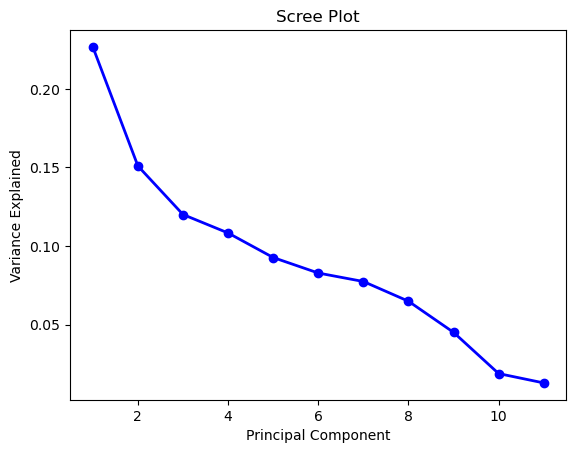

In [12]:
pca = PCA()
scaler = StandardScaler()

#making a copy to preserve the original unscaled df
combined_scaled = merged_df.copy()

#scaling each of the numerical columns
combined_scaled['Weekly_Sales'] = scaler.fit_transform(combined_scaled[['Weekly_Sales']])
combined_scaled['Temperature'] = scaler.fit_transform(combined_scaled[['Temperature']])
combined_scaled['Fuel_Price'] = scaler.fit_transform(combined_scaled[['Fuel_Price']])
combined_scaled['MarkDown1'] = scaler.fit_transform(combined_scaled[['MarkDown1']])
combined_scaled['MarkDown2'] = scaler.fit_transform(combined_scaled[['MarkDown2']])
combined_scaled['MarkDown3'] = scaler.fit_transform(combined_scaled[['MarkDown3']])
combined_scaled['MarkDown4'] = scaler.fit_transform(combined_scaled[['MarkDown4']])
combined_scaled['MarkDown5'] = scaler.fit_transform(combined_scaled[['MarkDown5']])
combined_scaled['CPI'] = scaler.fit_transform(combined_scaled[['CPI']])
combined_scaled['Unemployment'] = scaler.fit_transform(combined_scaled[['Unemployment']])
combined_scaled['Size'] = scaler.fit_transform(combined_scaled[['Size']])
combined_scaled['Weighted_Weekly_Sales'] = scaler.fit_transform(combined_scaled[['Weighted_Weekly_Sales']])
combined_scaled['Type'] = scaler.fit_transform(combined_scaled[['Type']])
combined_scaled.head()

#performing PCA on the numerical features. Which features we select will likely need tweaking
#pca.fit(combined_scaled[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Weighted_Weekly_Sales']])

pca.fit(combined_scaled[['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Type']])

print(pca.explained_variance_ratio_)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [13]:
# Define features and target variable
X = merged_df.drop(columns=['Weekly_Sales', 'Date', 'Holiday_Weight', 'Weighted_Weekly_Sales'])
X['Type'] = label_encoder.fit_transform(X['Type'])

y = merged_df['Weighted_Weekly_Sales']

# Initialize and fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)

output  = cross_validate(rf_model, X, y, cv= 10, scoring = 'r2', return_estimator =True)

# Display feature importances for each estimator
for idx, estimator in enumerate(output['estimator']):
    print(f"Features sorted by their score for estimator {idx}:")
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': estimator.feature_importances_
    }).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
         feature  importance
12          Size    0.282695
1      IsHoliday    0.254120
14         Month    0.123787
15    WeekOfYear    0.107876
6      MarkDown3    0.087197
2    Temperature    0.059877
0          Store    0.039273
9            CPI    0.021551
10  Unemployment    0.009490
3     Fuel_Price    0.004360
11          Type    0.001901
4      MarkDown1    0.001775
5      MarkDown2    0.001698
7      MarkDown4    0.001585
13          Year    0.001571
8      MarkDown5    0.001245
16     DayOfWeek    0.000000
Features sorted by their score for estimator 1:
         feature  importance
12          Size    0.280182
1      IsHoliday    0.241517
6      MarkDown3    0.107727
15    WeekOfYear    0.096347
14         Month    0.091572
2    Temperature    0.081550
0          Store    0.056839
9            CPI    0.018644
10  Unemployment    0.010960
3     Fuel_Price    0.005665
5      MarkDown2    0.002240
4      MarkDown1    0.001876
11   

In [14]:

# Define features and target variable
X = merged_df.drop(columns=['Weekly_Sales', 'Date', 'Holiday_Weight', 'Weighted_Weekly_Sales'])
X['Type'] = label_encoder.fit_transform(X['Type'])

y = merged_df['Weighted_Weekly_Sales']

# Initialize and fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)
rf_model.fit(X, y)

# Calculate feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances from Random Forest:")
print(feature_importances)


Feature Importances from Random Forest:
         Feature  Importance
12          Size    0.284016
1      IsHoliday    0.254311
6      MarkDown3    0.096989
14         Month    0.094516
15    WeekOfYear    0.092706
2    Temperature    0.079199
0          Store    0.046107
9            CPI    0.024169
10  Unemployment    0.011528
3     Fuel_Price    0.006570
11          Type    0.002714
5      MarkDown2    0.001892
4      MarkDown1    0.001491
13          Year    0.001371
8      MarkDown5    0.001227
7      MarkDown4    0.001194
16     DayOfWeek    0.000000


Mean Squared Error: 55519118632.61619
R-squared: 0.8276631011088188


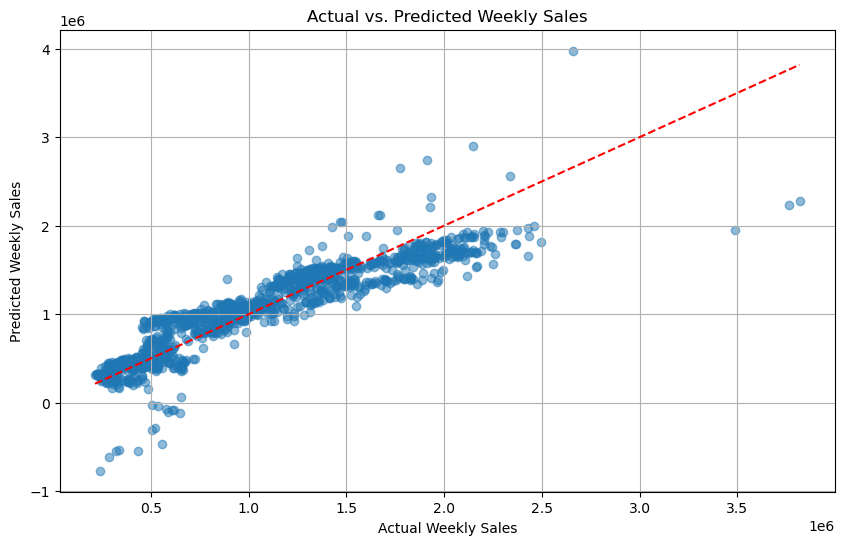

[-4.59997624e+03 -1.57591232e+04  5.79449978e+02  7.54230364e+03
  1.53665309e-01  1.12131512e+00 -8.50352183e+00  2.56701089e+00
  5.21894144e+00 -9.36318116e+02 -8.95683955e+03  6.78842483e+04
  4.81854800e+00 -2.13713461e+04  5.99070194e+03 -3.45959045e+05
  3.21703350e-01]


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np


X = merged_df.drop(columns=['WeekOfYear','Date', 'Weekly_Sales', 'DayOfWeek'])
y = merged_df['Weekly_Sales']

label_encoder = LabelEncoder()
X['Type'] = label_encoder.fit_transform(X['Type'])
X['IsHoliday'] = label_encoder.fit_transform(X['IsHoliday'])

linear_regression_model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_regression_model.fit(x_train, y_train)
y_pred = linear_regression_model.predict(x_test)

mse =mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs. Predicted Weekly Sales")
plt.grid(True)
plt.show()


print(linear_regression_model.coef_)

In [16]:
import pandas as pd
import numpy as np

output_dir = 'linearRegressionStorePredictions'
os.makedirs(output_dir, exist_ok=True) 

# Define the date range for 2013
dates_2013 = pd.date_range(start="2013-01-01", end="2013-12-31", freq='D')  # Daily granularity

# Start with the last known data from 2012 as "seed"
seed_data = merged_df[merged_df['Date'] == merged_df['Date'].max()].drop(columns=['WeekOfYear', 'Date', 'Weekly_Sales', 'DayOfWeek'])

# Ensure `Type` and `IsHoliday` are encoded correctly
seed_data['Type'] = label_encoder.transform(seed_data['Type'])
seed_data['IsHoliday'] = label_encoder.transform(seed_data['IsHoliday'])

# Get column names from training data
feature_columns = seed_data.columns

# Simulate predictions for each day in 2013
predictions_2013 = []

# Initialize seed input for prediction as a DataFrame
current_input = seed_data.iloc[0].copy()

for date in dates_2013:
    # Predict sales using a DataFrame with proper feature names
    predicted_sales = linear_regression_model.predict(pd.DataFrame([current_input], columns=feature_columns))
    
    # Save the result with the date
    predictions_2013.append({'Date': date, 'Predicted_Weekly_Sales': predicted_sales[0]})
    
    # Update the input for the next day
    # For simplicity, leave features unchanged except for updating the target prediction
    current_input.iloc[-1] = predicted_sales[0]  # Update the last feature with the predicted value

# Convert predictions to a DataFrame
predictions_2013_df = pd.DataFrame(predictions_2013)
output_file = os.path.join(output_dir, 'predicted_sales_2013.csv')
predictions_2013_df.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")

# Display the first few rows
print(predictions_2013_df.head())

Predictions saved to linearRegressionStorePredictions\predicted_sales_2013.csv
        Date  Predicted_Weekly_Sales
0 2013-01-01            1.313411e+06
1 2013-01-02            1.255424e+06
2 2013-01-03            1.236770e+06
3 2013-01-04            1.230768e+06
4 2013-01-05            1.228838e+06


In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 19 to 6413
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Store                  6435 non-null   int64         
 1   Date                   6435 non-null   datetime64[ns]
 2   IsHoliday              6435 non-null   bool          
 3   Temperature            6435 non-null   float64       
 4   Fuel_Price             6435 non-null   float64       
 5   MarkDown1              6435 non-null   float64       
 6   MarkDown2              6435 non-null   float64       
 7   MarkDown3              6435 non-null   float64       
 8   MarkDown4              6435 non-null   float64       
 9   MarkDown5              6435 non-null   float64       
 10  CPI                    6435 non-null   float64       
 11  Unemployment           6435 non-null   float64       
 12  Type                   6435 non-null   int32         
 13  Size   

Mean Squared Error: 179480660361.059
R-squared: 0.8726664528408563


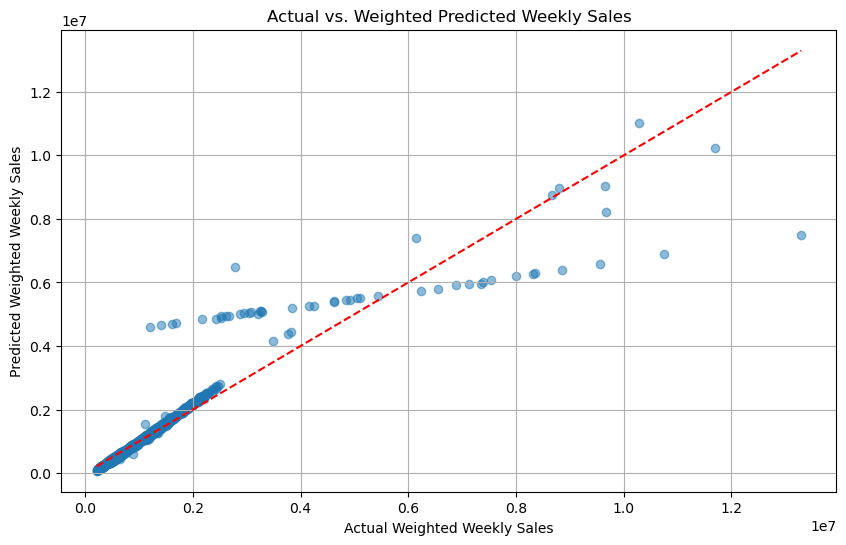

[ 8.56443798e+02  1.40916519e+04 -2.41960960e+02 -3.95713544e+03
  2.05582944e+00 -1.55465525e+00  4.03974540e+01 -3.79641518e+00
 -4.21383480e+00  4.09598423e+01 -2.47021300e+03 -5.25937602e+03
 -6.55717975e-01  1.24265422e+00 -6.34185383e+03 -2.70435950e+03
  0.00000000e+00  1.12007138e+06]


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np


X = merged_df.drop(columns=['WeekOfYear', 'Date', 'Weighted_Weekly_Sales'])
y = merged_df['Weighted_Weekly_Sales']

label_encoder = LabelEncoder()
X['Type'] = label_encoder.fit_transform(X['Type'])

linear_regression_model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_regression_model.fit(x_train, y_train)
y_pred = linear_regression_model.predict(x_test)

mse =mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Weighted Weekly Sales")
plt.ylabel("Predicted Weighted Weekly Sales")
plt.title("Actual vs. Weighted Predicted Weekly Sales")
plt.grid(True)
plt.show()


print(linear_regression_model.coef_)

C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 1878995219872.901
Correlation: 0.6952380588567774


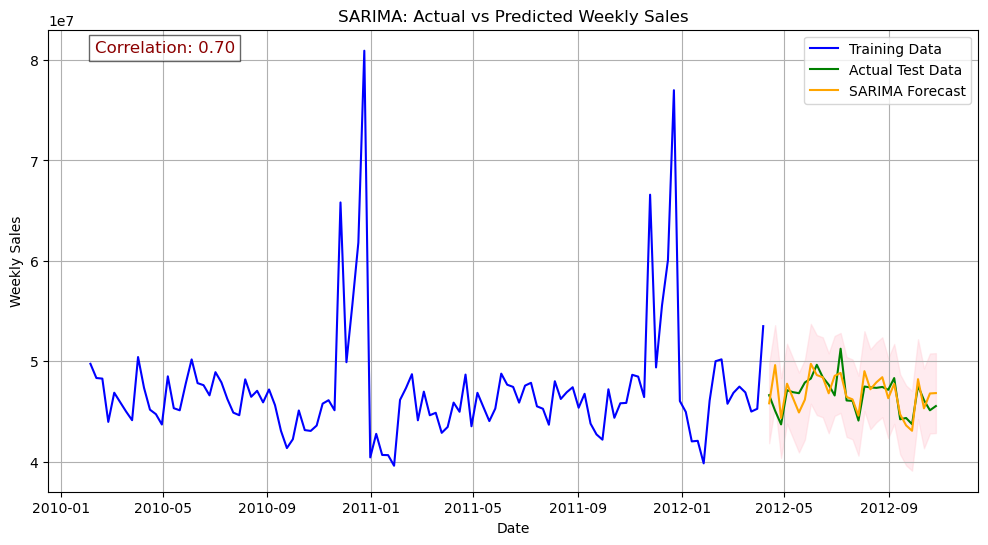

In [19]:

store_df = merged_df[['Date', 'Weekly_Sales', 'Weighted_Weekly_Sales']]
store_df = store_df.reset_index(drop=True)


unweighted_store_df = store_df[['Date', 'Weekly_Sales']]
unweighted_store_df = unweighted_store_df.groupby('Date', as_index=False)['Weekly_Sales'].sum()

unweighted_store_df.set_index('Date', inplace=True)

unweighted_store_df.head()

y = unweighted_store_df['Weekly_Sales']

train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]


sarima_order = (1, 0, 1)
seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)


model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = model.fit(disp=False)


forecast = sarima_fit.get_forecast(steps=len(y_test))
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


mse = mean_squared_error(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

print(f"Mean Squared Error: {mse}")
print(f"Correlation: {correlation}")


plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(y_train.index, y_train, label='Training Data', color='blue')

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

# Plot predictions
plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA: Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)

# Add correlation as text to the plot
plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
         transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

plt.show()


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 2330495431749.297
Correlation: 0.9992646856108667


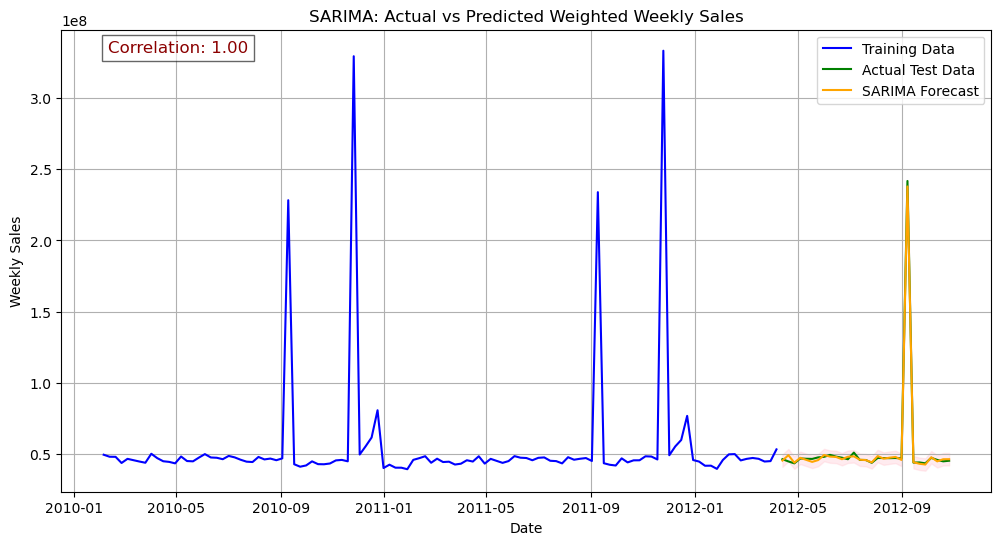

In [20]:

store_df = merged_df[['Date', 'Weekly_Sales', 'Weighted_Weekly_Sales']]
store_df = store_df.reset_index(drop=True)

weighted_store_df = store_df[['Date', 'Weighted_Weekly_Sales']]
weighted_store_df = weighted_store_df.groupby('Date', as_index=False)['Weighted_Weekly_Sales'].sum()

weighted_store_df.set_index('Date', inplace=True)

weighted_store_df.head()

y = weighted_store_df['Weighted_Weekly_Sales']

train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]


sarima_order = (1, 0, 1)
seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)


model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = model.fit(disp=False)


forecast = sarima_fit.get_forecast(steps=len(y_test))
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


mse = mean_squared_error(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

print(f"Mean Squared Error: {mse}")
print(f"Correlation: {correlation}")


plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(y_train.index, y_train, label='Training Data', color='blue')

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

# Plot predictions
plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA: Actual vs Predicted Weighted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)

# Add correlation as text to the plot
plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
         transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

plt.show()


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a s

Mean Squared Error: 87808499526.33475
Correlation: 0.8386914625837399


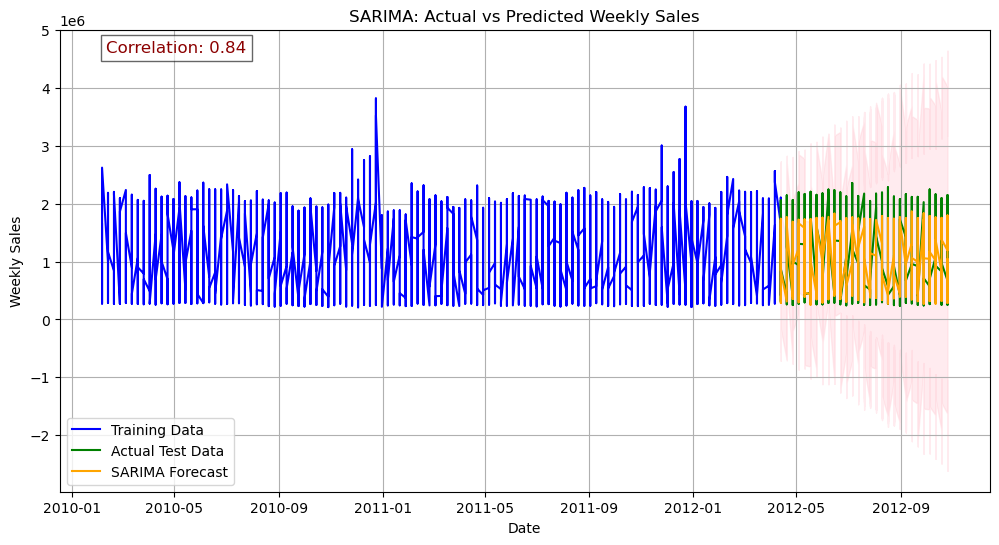

In [21]:
#Test with using multiple variables


unweighted_store_df = merged_df.copy()
unweighted_store_df.sort_values(by='Date', inplace=True)

unweighted_store_df.set_index('Date', inplace=True)

unweighted_store_df.head()

y = unweighted_store_df['Weekly_Sales']

train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]


sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)

exog = unweighted_store_df[['Size']]
exog_train, exog_test = exog[:train_size], exog[train_size:]


model = SARIMAX(y_train, exog=exog_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = model.fit(disp=False)



forecast = sarima_fit.get_forecast(steps=len(y_test), exog=exog_test)
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


mse = mean_squared_error(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

print(f"Mean Squared Error: {mse}")
print(f"Correlation: {correlation}")


plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(y_train.index, y_train, label='Training Data', color='blue')

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

# Plot predictions
plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA: Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)

# Add correlation as text to the plot
plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
         transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

plt.show()


            Weekly_Sales    Size
Date                            
2010-02-05   49750740.50  151315
2010-02-12   48336677.63  151315
2010-02-19   48276993.78  151315
2010-02-26   43968571.13  151315
2010-03-05   46871470.30  151315


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 36420899744855.234
Correlation: 0.7094381530859236


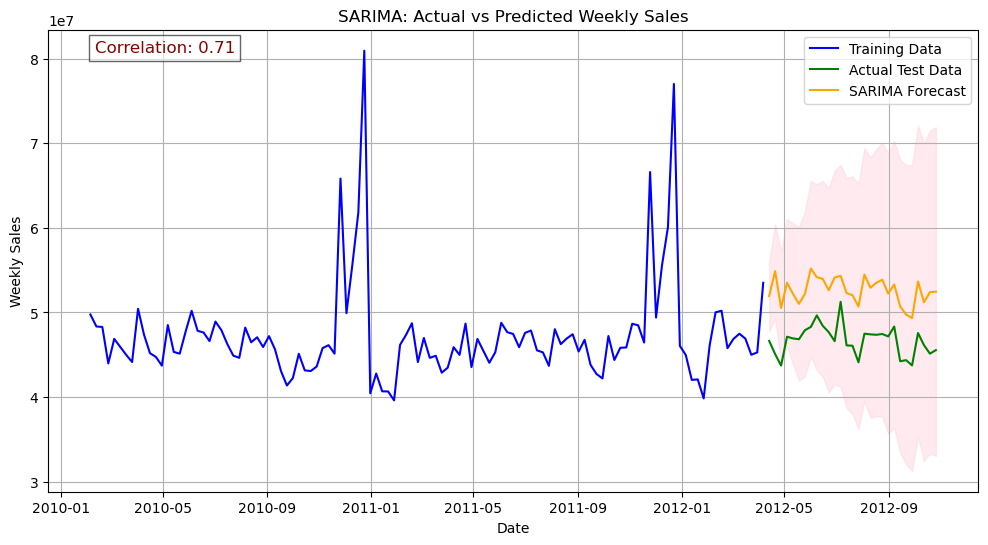

In [22]:
# Drop the 'Weighted_Weekly_Sales' column (if applicable) and sort by date
new_unweighted_store_df = merged_df.copy()

new_unweighted_store_df.reset_index

# Group by 'Date' and apply custom aggregation
new_unweighted_store_df = new_unweighted_store_df.groupby('Date', as_index=False).agg({
    'Weekly_Sales': 'sum',  # Sum Weekly Sales
    'Size': 'first',         # Use the first Size value for each group (or replace with 'mean', 'mode', etc.)
})

# Sort and set 'Date' as the index
new_unweighted_store_df.set_index('Date', inplace=True)

# Verify the results
print(new_unweighted_store_df.head())

# Extract the target variable (y) and exogenous variable (Size)
y = new_unweighted_store_df['Weekly_Sales']
exog = new_unweighted_store_df[['Size']]

# Split data into training and testing sets
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

# Fit the SARIMAX model
model = SARIMAX(y_train, exog=exog_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = model.fit(disp=False)

# Forecasting
forecast = sarima_fit.get_forecast(steps=len(y_test), exog=exog_test)
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]

print(f"Mean Squared Error: {mse}")
print(f"Correlation: {correlation}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Training Data', color='blue')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')
plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA: Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.text(
    x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
    transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6)
)
plt.show()

In [23]:
output_dir = 'storePredictions'
os.makedirs(output_dir, exist_ok=True)

store_df = merged_df[['Date', 'Store', 'Weekly_Sales', 'Weighted_Weekly_Sales']]
store_df = store_df.reset_index(drop=True)


unweighted_store_df = store_df[['Date', 'Store', 'Weekly_Sales']]

unweighted_store_df['Store'].unique()

for store_id in unweighted_store_df['Store'].unique():

    unweighted_df = unweighted_store_df.loc[unweighted_store_df['Store'] == store_id]
    unweighted_df = unweighted_df[['Date', 'Weekly_Sales']]

    unweighted_df.set_index('Date', inplace=True)

    y = unweighted_df['Weekly_Sales']

    train_size = int(len(y) * 0.8)
    y_train, y_test = y[:train_size], y[train_size:]


    sarima_order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)


    model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
    sarima_fit = model.fit(disp=False)


    forecast = sarima_fit.get_forecast(steps=len(y_test))
    y_pred = forecast.predicted_mean
    conf_int = forecast.conf_int()


    mse = mean_squared_error(y_test, y_pred)
    correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

    print(f"Mean Squared Error: {mse}")
    print(f"Correlation: {correlation}")


    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(y_train.index, y_train, label='Training Data', color='blue')

    # Plot actual test data
    plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

    # Plot predictions
    plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


    plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    plt.title('SARIMA: Actual vs Predicted Weekly Sales')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)

    # Add correlation as text to the plot
    plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
            transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

    
    filename = os.path.join(output_dir, f'Store_{store_id}_Forecasting.png')
    plt.savefig(filename)
    plt.close()





C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 44069038497.19683
Correlation: 0.7582454978768333


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 29303766941.673927
Correlation: 0.5969813020861013


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3895387635.638245
Correlation: 0.5995276592087552


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 76100194307.35666
Correlation: 0.5040102514024725


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3063371484.8306694
Correlation: 0.7007032620142367


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 51551055330.71946
Correlation: 0.8012124197507731


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 10638064378.100939
Correlation: 0.9359952958536364


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 4740366492.367423
Correlation: 0.5030929182026511


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 7457016598.107827
Correlation: 0.6505832109269656


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 62782762447.96998
Correlation: 0.4714791148191696


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 41164707219.514534
Correlation: 0.46737591379638177


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8540532448.0925455
Correlation: 0.8115487264371857


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 74805968726.74475
Correlation: 0.3032015585741831


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 243945811284.90167
Correlation: 0.5372040343125257


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 5592839138.611278
Correlation: 0.7113376415493112


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 2360446282.270845
Correlation: 0.9192594919343501


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8301382118.515034
Correlation: 0.9163813587841051


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 14223142277.250233
Correlation: 0.3687871783285007


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 44374393162.42344
Correlation: 0.6712176834416874


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 174448286508.0048
Correlation: 0.3805992898160784


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 4272535002.5708413
Correlation: 0.7004682611530151


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 28113791665.304054
Correlation: 0.6931198881688024


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 50326665080.93065
Correlation: 0.7601633699467034


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 30759424419.2786
Correlation: 0.79542042356267


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 13243158718.52023
Correlation: 0.49113892743716847


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 10888772824.727068
Correlation: 0.8354744273929265


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 28731029300.6939
Correlation: 0.8106670110555394


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 20913582239.279427
Correlation: 0.744473071523986


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8077270296.269403
Correlation: 0.7093018473960744


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 451959734.8141336
Correlation: 0.23650932003479053


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 7960321583.673461
Correlation: 0.7258530000555732


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 17228238480.66979
Correlation: 0.4975313904722491


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 267733386.90887606
Correlation: 0.8299594083993221


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 5988617409.574627
Correlation: 0.5838535705297723


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3784339179.488301
Correlation: 0.46806542027383835


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 829428625.1297657
Correlation: 0.7795471913689995


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 533697610.11731505
Correlation: 0.23711203202279008


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 3102670156.8178678
Correlation: 0.6278010186138935


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 91387905039.4375
Correlation: 0.6089653828901289


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 17876974714.42832
Correlation: 0.8492067039634317


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 17346333829.081837
Correlation: 0.7460250457078718


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 1100728745.369739
Correlation: 0.817402648188217


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 490857536.10670316
Correlation: 0.802619671839712


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 194868111.58394954
Correlation: 0.3829030379285221


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 14762879967.941723
Correlation: 0.6158236368777119


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 36425092672857.06
Correlation: 0.7094336568261853


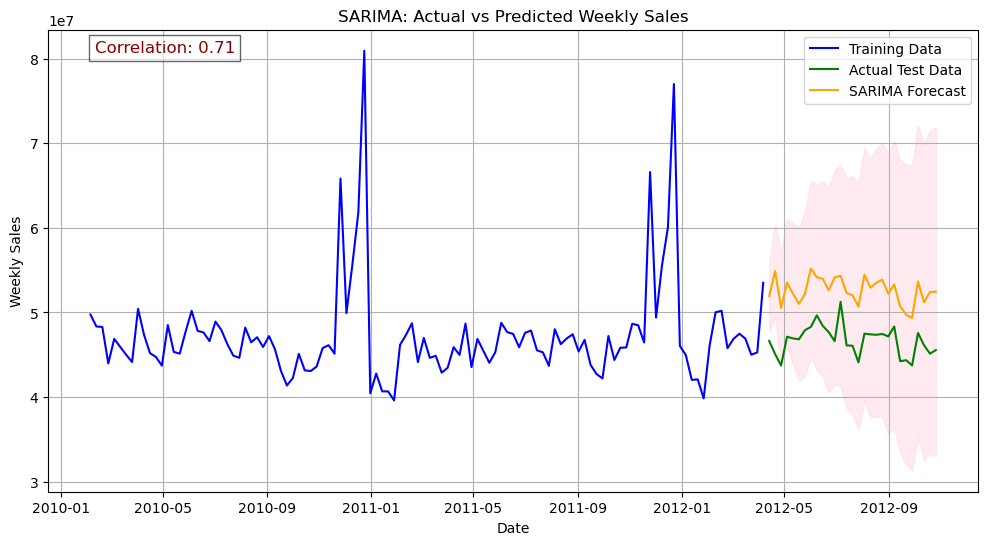

In [24]:

store_df = merged_df[['Date', 'Weekly_Sales', 'Weighted_Weekly_Sales']]
store_df = store_df.reset_index(drop=True)


unweighted_store_df = store_df[['Date', 'Weekly_Sales']]
unweighted_store_df = unweighted_store_df.groupby('Date', as_index=False)['Weekly_Sales'].sum()

unweighted_store_df.set_index('Date', inplace=True)

unweighted_store_df.head()

y = unweighted_store_df['Weekly_Sales']

train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]


sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)


model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = model.fit(disp=False)


forecast = sarima_fit.get_forecast(steps=len(y_test))
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


mse = mean_squared_error(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

print(f"Mean Squared Error: {mse}")
print(f"Correlation: {correlation}")


plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(y_train.index, y_train, label='Training Data', color='blue')

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

# Plot predictions
plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA: Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)

# Add correlation as text to the plot
plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
         transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

plt.show()
